### Libraries

In [1]:
import sys, os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from utils.EDA import vis_numeric_corr_matrix

In [2]:
load_dotenv()
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

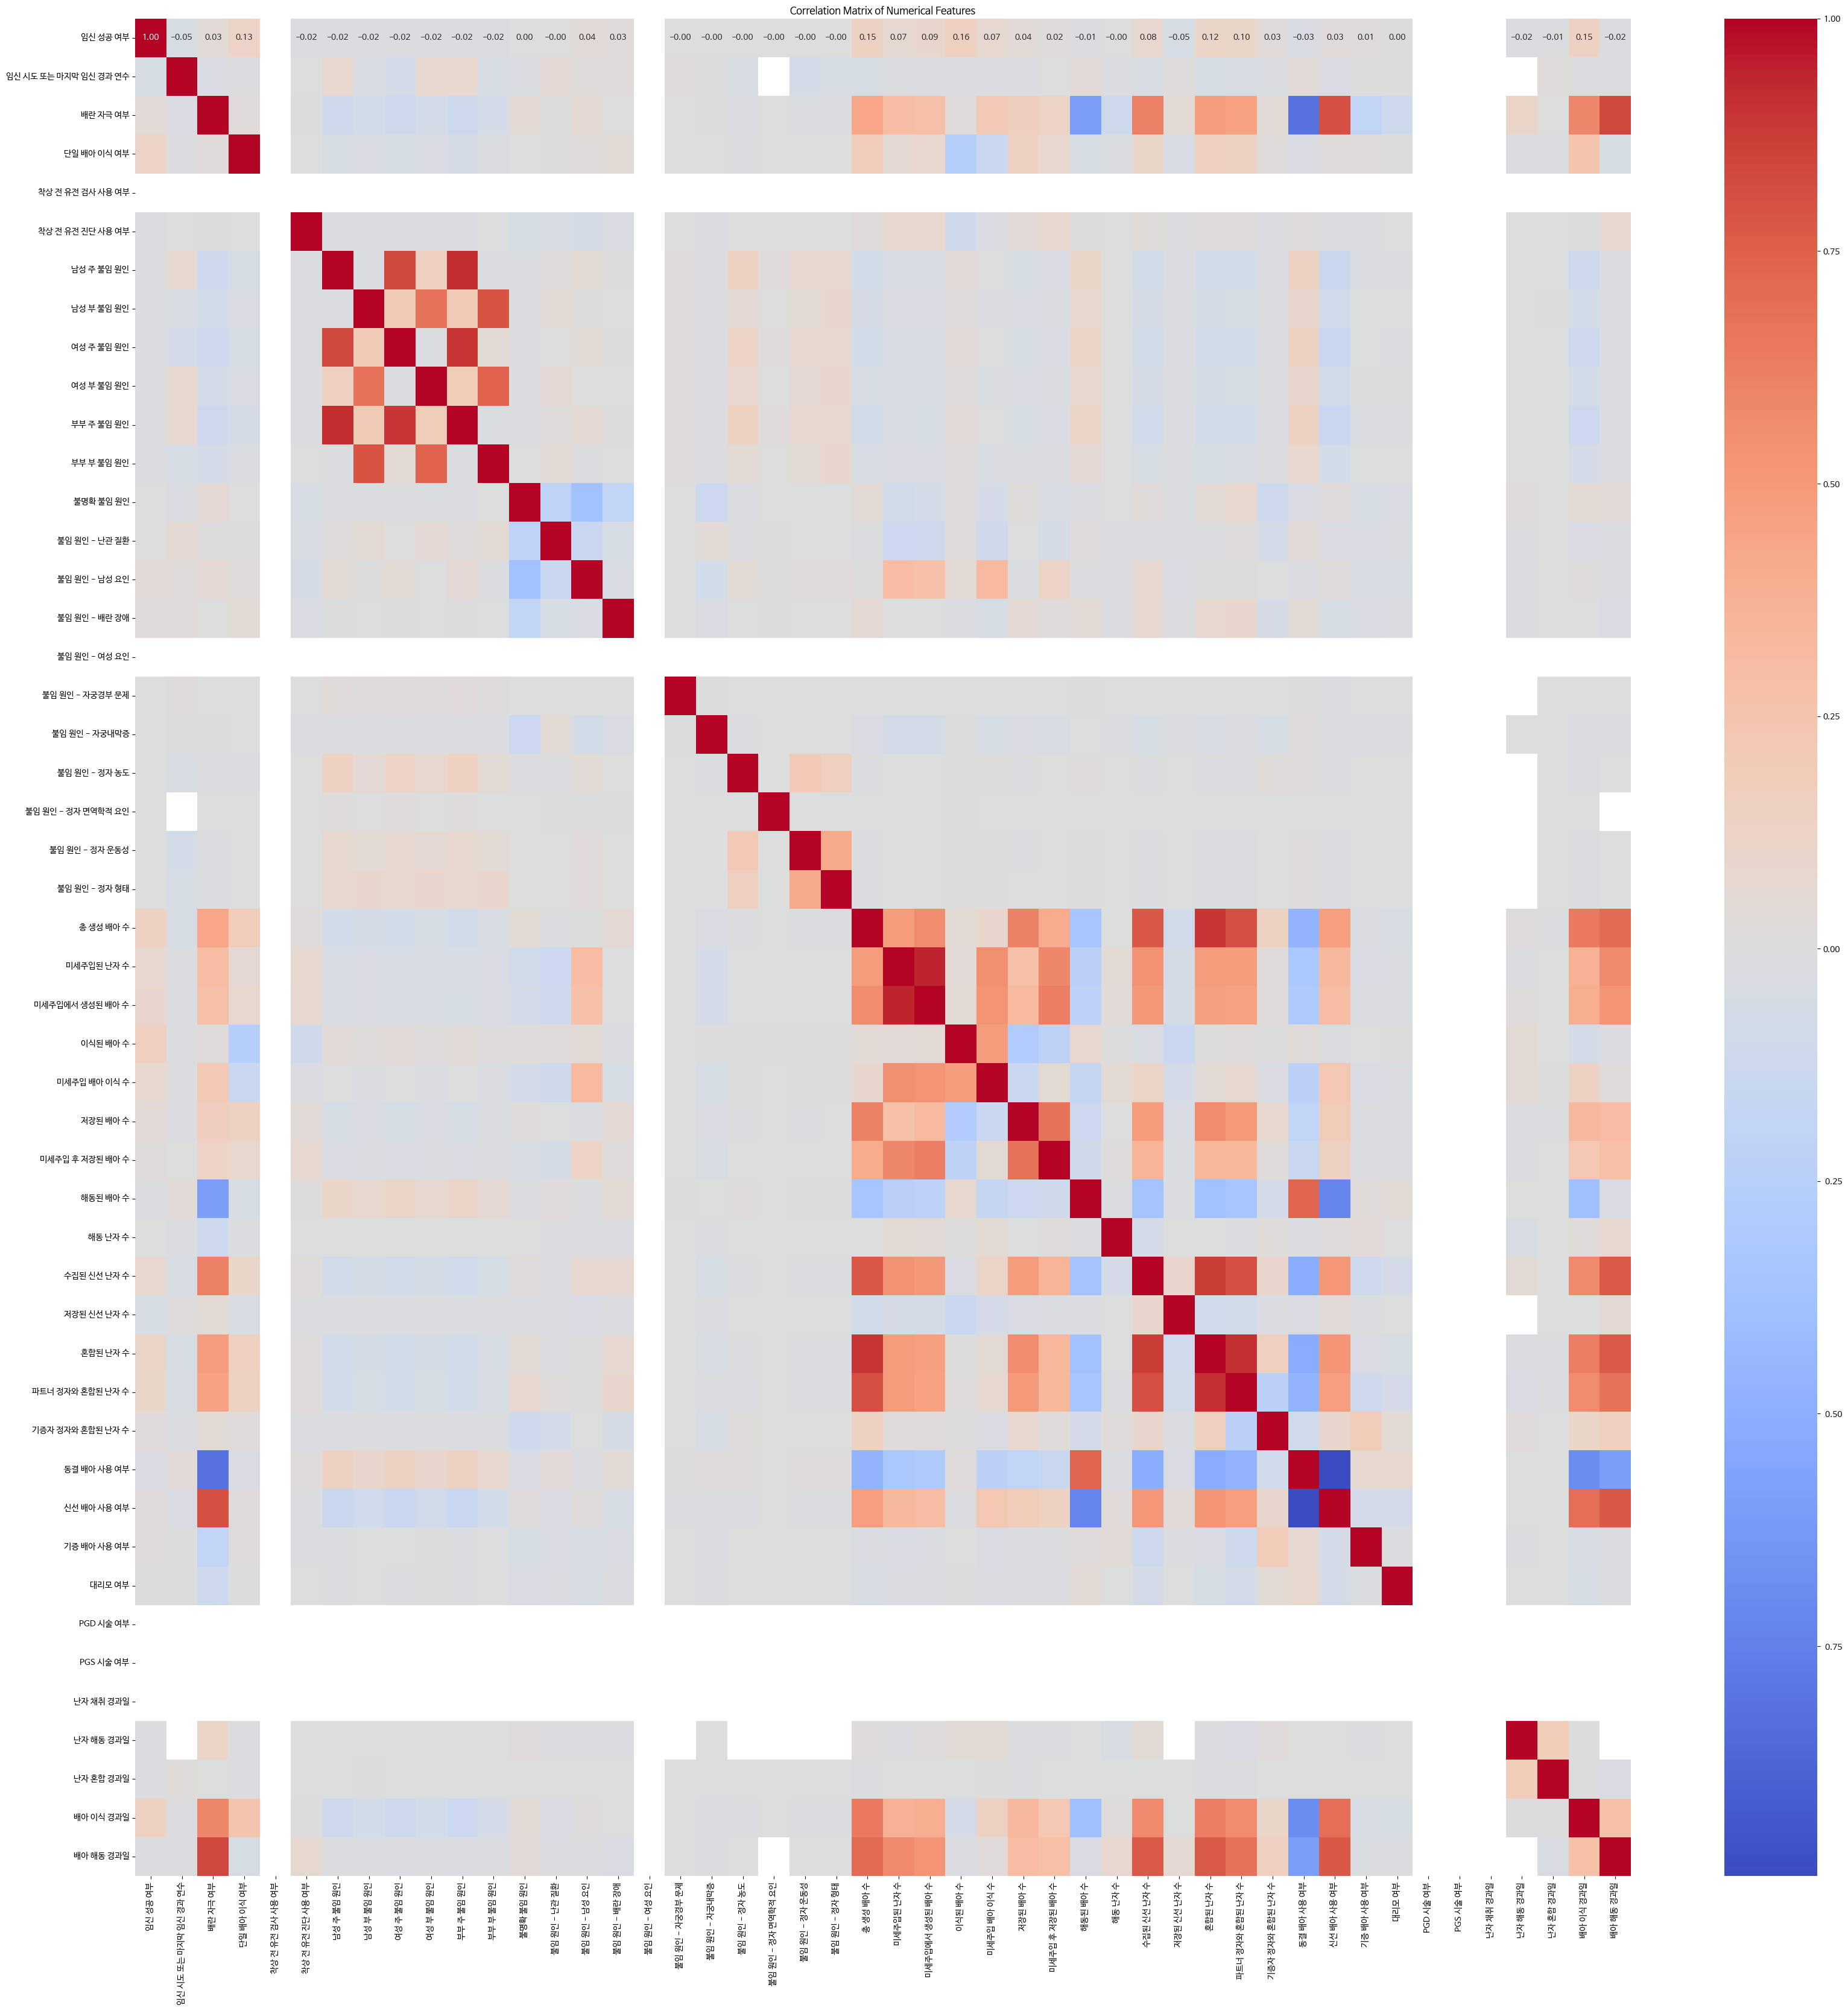

Column 일치 여부 : False
Train Row 수 :256351
Test Row 수 :90067


In [3]:
TRAIN_PATH = os.getenv('TRAIN_DATA_PATH')
TEST_PATH = os.getenv('TEST_DATA_PATH')

train = pd.read_csv(TRAIN_PATH).drop(columns=['ID'])
test = pd.read_csv(TEST_PATH)
vis_numeric_corr_matrix(train) #<--- for visualizing corr matrix
print(f"Column 일치 여부 : {train.columns.values.tolist()[:-1] == test.columns.values.tolist()}")
print(f"Train Row 수 :{len(train)}")
print(f"Test Row 수 :{len(test)}")

### Preprocessing

In [4]:
from utils.feature import preprocess
pre_train = preprocess(train = train)
pre_test = preprocess(train = test, validation= True)

In [5]:
# 결측 비율 확인
pre_train.isnull().mean(), pre_test.isnull().mean()

(시술 시기 코드                 0.0
 시술 당시 나이                 0.0
 임신 시도 또는 마지막 임신 경과 연수    0.0
 시술 유형                    0.0
 특정 시술 유형                 0.0
                         ... 
 난자 해동 경과일                0.0
 난자 혼합 경과일                0.0
 배아 이식 경과일                0.0
 배아 해동 경과일                0.0
 임신 성공 여부                 0.0
 Length: 67, dtype: float64,
 ID                       0.0
 시술 시기 코드                 0.0
 시술 당시 나이                 0.0
 임신 시도 또는 마지막 임신 경과 연수    0.0
 시술 유형                    0.0
                         ... 
 난자 채취 경과일                0.0
 난자 해동 경과일                0.0
 난자 혼합 경과일                0.0
 배아 이식 경과일                0.0
 배아 해동 경과일                0.0
 Length: 67, dtype: float64)

### Feature engineering

In [6]:
pre_train['총 임신 횟수'].value_counts()
pre_train['총 출산 횟수'].value_counts()

총 출산 횟수
0    222016
1     35962
2      2274
3       171
4        13
6         2
5         1
Name: count, dtype: int64

In [7]:
from utils.ft_generator import feature_engineering
df_train = feature_engineering(pre_train)
df_test = feature_engineering(pre_test)
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)
print(len(df_train.columns))
# vis_numeric_corr_matrix(df_train)

시술 시기 코드                 0.0
시술 당시 나이                 0.0
임신 시도 또는 마지막 임신 경과 연수    0.0
시술 유형                    0.0
특정 시술 유형                 0.0
                        ... 
PGD 사용                   0.0
배란유도_0                   0.0
배란유도_1                   0.0
난자 채취-이식 경과 비율           0.0
배아 해동 이후 이식 기간           0.0
Length: 96, dtype: float64
96


In [8]:
# Nan Inf Detect
from utils.EDA import find_inf_nan_columns

find_inf_nan_columns(df_train)

{'inf_col': [], 'nan_col': []}

### Feature selection

### Modeling

In [9]:
from utils.model import bool_process, split_cat_num_cols
from utils.data import check_non_numeric_values

X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']

#########################
# 2) 카테고리/연속형 컬럼 분리
#########################
X = bool_process(X)
check_non_numeric_values(df=X)
category_cols, continuous_cols = split_cat_num_cols(X, cat_unique_threshold=20)


print(f"범주형 자료 개수 : {len(category_cols)}")
print(f"연속형 자료 개수 : {len(continuous_cols)}")
X[category_cols] = bool_process(X[category_cols])


# Data split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)

X_test = df_test
X_test[category_cols] = bool_process(X_test[category_cols])

print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape)


from sklearn.preprocessing import LabelEncoder
for col in category_cols:
    le = LabelEncoder()
    # 전체 데이터의 해당 컬럼을 합쳐서 fit
    combined = pd.concat([X_train[col], X_valid[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_valid[col] = le.transform(X_valid[col].astype(str))
    X_test[col]  = le.transform(X_test[col].astype(str))



검사 및 결측치 확인 상태 : 무결성
범주형 자료 개수 : 41
연속형 자료 개수 : 54
X_train.shape: (208351, 95)
X_val.shape: (52088, 95)
y_train.shape: (208351,)
y_val.shape: (52088,)
X_test.shape: (91512, 96)


#### 일반

In [10]:
from utils.metric import print_evaluation_metrics, evaluate_model
from tabpfn import TabPFNClassifier
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch
from tab_transformer_pytorch import FTTransformer
from chempfn import ChemPFN

from utils.model import *

# # # 모델 정의
# cat_model = CatBoostClassifier(
#     iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
#     subsample=0.8, colsample_bylevel=0.8, random_strength=10,
#     loss_function='Logloss', eval_metric='AUC', verbose=100
# )

# xgb_model = XGBClassifier(
#     n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
#     gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
#     reg_lambda=1.0, verbosity=1
# )

# lgbm_model = LGBMClassifier(
#     n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
#     min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
#     reg_alpha=0.1, reg_lambda=1.0, verbosity=1
# )

# ensemble_model = VotingClassifier(
#     estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model)],
#     voting='soft', weights=[1, 1, 1]
# )

# tabpfn_model = TabPFNClassifier()

# tabnet_model = TabNetClassifier()



### Tuning

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch


from ts3l.pl_modules import SwitchTabLightning
from ts3l.utils.switchtab_utils import SwitchTabDataset, SwitchTabFirstPhaseCollateFN, SwitchTabConfig
from ts3l.utils import TS3LDataModule
from ts3l.utils.embedding_utils import FTEmbeddingConfig
from ts3l.utils.backbone_utils import TransformerBackboneConfig
from ts3l.utils.misc import get_category_cardinality
from pytorch_lightning import Trainer


In [12]:
# 1-1) train/valid split
metric = "roc_auc_score"
input_dim = X_train.shape[1]
hidden_dim = 1024
output_dim = 2          # 이진분류 예시

encoder_depth = 3
n_head = 2
u_label = -1

device = 'gpu'
batch_size = 128

max_epochs = 2
seed = 123


In [13]:
embedding_config = FTEmbeddingConfig(input_dim = input_dim, emb_dim = 128, cont_nums = len(continuous_cols),
                                        cat_cardinality=get_category_cardinality(X_train, category_cols), required_token_dim=2)

backbone_config = TransformerBackboneConfig(d_model = embedding_config.emb_dim, encoder_depth = encoder_depth, n_head = n_head, hidden_dim = hidden_dim)

config = SwitchTabConfig(
    task="classification",            # 분류 태스크
    loss_fn="CrossEntropyLoss",
    metric=metric,
    embedding_config=embedding_config,
    backbone_config=backbone_config,
    output_dim=output_dim,
    u_label = u_label,
)



In [14]:

pl_switchtab = SwitchTabLightning(config)

train_ds = SwitchTabDataset(X = X_train, unlabeled_data = X_test.drop(columns='ID'), config = config, continuous_cols=continuous_cols, category_cols=category_cols)
valid_ds = SwitchTabDataset(X = X_valid, config = config, continuous_cols=continuous_cols, category_cols=category_cols)
datamodule = TS3LDataModule(train_ds, valid_ds, batch_size=batch_size, train_sampler="random",
                            train_collate_fn= SwitchTabFirstPhaseCollateFN(),
                            valid_collate_fn= SwitchTabFirstPhaseCollateFN())
trainer = Trainer(
    accelerator=device,      # GPU 사용 가능하면 'gpu' or 'auto'
    max_epochs=max_epochs,
    num_sanity_val_steps=2,
)
trainer.fit(pl_switchtab, datamodule) # First Training 


pl_switchtab.set_second_phase()
train_ds = SwitchTabDataset(X = X_train, Y = y_train.values, continuous_cols=continuous_cols, category_cols=category_cols, is_second_phase=True)
valid_ds = SwitchTabDataset(X = X_valid, Y = y_valid.values, continuous_cols=continuous_cols, category_cols=category_cols, is_second_phase=True)
datamodule = TS3LDataModule(train_ds, valid_ds, batch_size = batch_size, train_sampler="weighted")
trainer = Trainer(
    accelerator=device,
    max_epochs=max_epochs,
    num_sanity_val_steps=2,
)
trainer.fit(pl_switchtab, datamodule)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type             | Params | Mode 
--------------------------------------------------------------------
0 | task_loss_fn           | CrossEntropyLoss | 0      | train
1 | reconstruction_loss_fn | MSELoss          | 0      | train
2 | model                  | SwitchTab        | 1.9 M  | train
--------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type             | Params | Mode 
--------------------------------------------------------------------
0 | task_loss_fn           | CrossEntropyLoss | 0      | train
1 | reconstruction_loss_fn | MSELoss          | 0      | train
2 | model                  | SwitchTab        | 1.9 M  | train
--------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.503     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [30]:
# Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, SequentialSampler

test_ds = SwitchTabDataset(X_valid, continuous_cols=continuous_cols, category_cols=category_cols, is_second_phase=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, sampler = SequentialSampler(test_ds), num_workers=12)

preds = trainer.predict(pl_switchtab, test_dl)
preds = F.softmax(torch.concat([out.cpu() for out in preds]).squeeze(),dim=1)

accuracy = accuracy_score(y_valid, preds.argmax(1))
auroc = roc_auc_score(y_valid, preds.argmax(1))

print("Accuracy %.2f" % accuracy)
print("auroc %.2f" % auroc)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Accuracy 0.74
auroc 0.50


#### Stratified K-Fold 

In [16]:
from utils.data import preprocess_data,handle_inf_and_fillna
import numpy as np

df = X_train

# df.isin([np.inf, -np.inf])은 불리언 마스크
mask_inf = df.isin([np.inf, -np.inf])
if mask_inf.any().any():
    inf_cols = mask_inf.any()[mask_inf.any() == True].index
    print("inf값이 존재하는 컬럼:", inf_cols)

# 최대/최소값이 너무 큰 컬럼 찾기
for col in df.columns:
    max_val = df[col].max()
    min_val = df[col].min()
    if max_val > 1e15 or min_val < -1e15:
        print(f"컬럼 {col} 범위가 너무 큼: min={min_val}, max={max_val}")


In [17]:
# Stratified K-Fold 설정
n_splits = 5
batch_size = 486

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
metrics = {model: [] for model in ['Custom Model']}
k_fold_models = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


    #%% ML_Method
    # k_fold_model = CatBoostClassifier(
    #     iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
    #     subsample=0.8, colsample_bylevel=0.8, random_strength=10,
    #     loss_function='Logloss', eval_metric='AUC', verbose=100
    # )
    
    k_fold_model = VotingClassifier(
        estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model)],
        voting='soft', weights=[1, 1, 1]
    )    

    
    k_fold_model = ml_trainer(k_fold_model, X_train, y_train)
    

    #%% TabFN Model
    # k_fold_model = tabpfn_model
    # k_fold_model = tabfn_trainer(k_fold_model, X_train, y_train, batch_size = 256)
    
    # #%% TabNet
    # k_fold_model = tabnet_model
    # k_fold_model = tabnet_trainer(k_fold_model = k_fold_model, X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val)
    

    # #%% Ftt
    # cat_cols, num_cols = split_cat_num_cols(X, cat_unique_threshold= 10)
    # k_fold_model =  ftt_trainer(X_train, y_train, X_val, y_val, cat_cols, num_cols, num_cols)
        
    
    k_fold_models.append(k_fold_model)
    # 평가
    for model_name, model in zip(metrics.keys(), [k_fold_model]):
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

===== Fold 1 =====


NameError: name 'cat_model' is not defined

In [ ]:
for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.8f}")
metrics


== Custom Model Model ==
Accuracy: 0.74455055
Precision: 0.54172313
Recall: 0.11274579
F1 Score: 0.18661559
ROC AUC Score: 0.74008985


### Prediction

In [ ]:
def mean_ID_extract(df:pd.DataFrame):
    df['probability'] = df.groupby('ID')['probability'].transform('mean')
    df_unique = df.drop_duplicates(subset=['ID'], keep='first').reset_index(drop=True)
    return df_unique

def max_ID_extract(df:pd.DataFrame):
    df['probability'] = df.groupby('ID')['probability'].transform('max')
    df_unique = df.drop_duplicates(subset=['ID'], keep='first').reset_index(drop=True)
    return df_unique

# counts = df_test['ID'].value_counts()
# repeated_ids = counts[counts > 1].index  # 2번 이상 등장하는 ID만 뽑아냄

# # 인덱스 목록으로 필터링하여, 해당 ID를 가진 행만 추출
# df_repeated = df_test[df_test['ID'].isin(repeated_ids)]
# df_repeated

# df_mean = mean_ID_extract(df_repeated)
# df_mean

# df_max = max_ID_extract(df_repeated)
# df_max

# (df_mean['probability'] == df_max['probability']).value_counts()

In [ ]:
from utils.EDA import vis_prob_barchart
# 평가 지표 평균 출력
for idx, model in enumerate(k_fold_models):
    # df_test를 수정하지 않고, drop(columns='ID')만 해서 사용
    pred_proba = model.predict_proba(df_test.drop(columns='ID'))[:, 1]
    
    # df_test에 probability 컬럼을 만들지 않고, 바로 max_ID_extract에 넣을 임시 DF를 만듦
    temp_df = df_test[['ID']].copy()
    temp_df['probability'] = pred_proba
    
    pred_proba_max = max_ID_extract(temp_df)['probability']
    test[f'probability_{idx+1}'] = pred_proba_max

# test에 probability_1 ~ probability_5 컬럼이 있을 때
pred_main_proba = test[[
    'probability_1',
    'probability_2',
    'probability_3',
    'probability_4',
    'probability_5'
]].mean(axis=1)

pred_main_proba

### Submission

In [ ]:
SUBMISSION_DATA_PATH = os.getenv('SUBMISSION_DATA_PATH')
sample_submission = pd.read_csv(SUBMISSION_DATA_PATH)
sample_submission['probability'] = pred_main_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}.csv')
print(f"save path : {save_path}")
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

In [ ]:
# 확인용
submission = pd.read_csv(save_path)

In [ ]:
submission
